In [8]:
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
import numpy as np
# %matplotlib inline
from spectral_cube import SpectralCube
from astropy import units as u
results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'

In [2]:
import glob
cubefns = glob.glob(f"{results}/source_ab_*_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image")
cubefns = glob.glob(f"{results}/*.image.pbcor")

In [4]:
from astropy import coordinates, units as u
from astropy import wcs
from astropy.io import fits

In [5]:
crd = coordinates.SkyCoord("17:46:10.80 -28:42:13.3", frame='fk5', unit=(u.h, u.deg))

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
cubes = []

for fn in cubefns:

    ch3cncube = SpectralCube.read(fn, format='casa_image')
    
    ch3cntbl = ch3cncube.find_lines(chemical_name='CH3CN', line_lists=['JPL'], 
                                    show_upper_degeneracy=True, show_qn_code=True)
    ch3cntbl = ch3cntbl[ch3cntbl['Quantum Number Code'] == 202]
    if len(ch3cntbl) > 0:
        cubes.append(ch3cncube)
        print(fn)
        print(ch3cntbl)
    if any('(0)' in x for x in ch3cntbl['Resolved QNs']):
        msk = np.array(['(0)' in x for x in ch3cntbl['Resolved QNs']])
        restfrq = ch3cntbl[msk]['Freq-GHz(rest frame,redshifted)'].value
        qns = str(ch3cntbl[msk]['Resolved QNs'][0]).replace("(","").replace(")","")
        for rf, qn in zip(restfrq, qns):
            print(fn, qn, rf)
            ccube = ch3cncube.with_spectral_unit(u.km/u.s, rest_value=rf*u.GHz, velocity_convention='radio').spectral_slab(-50*u.km/u.s, 350*u.km/u.s)
            ccube.to(u.K).write(f'/orange/adamginsburg/brick_alma_linesurvey/ch3cn_cutouts/CH3CN_{qn}.pbcor.fits', overwrite=True)


/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/BrickMaser_257_spw45.image.pbcor
Species  Chemical Name  Freq-GHz(rest frame,redshifted) Freq Err(rest frame,redshifted) Meas Freq-GHz(rest frame,redshifted) Meas Freq Err(rest frame,redshifted)  Resolved QNs CDMS/JPL Intensity ... E_L (cm^-1)  E_L (K)   E_U (cm^-1)  E_U (K)   Upper State Degeneracy Quantum Number Code Linelist
-------- -------------- ------------------------------- ------------------------------- ------------------------------------ ------------------------------------ ------------- ------------------ ... ----------- ---------- ----------- ---------- ---------------------- ------------------- --------
CH3CNv=0 Methyl Cyanide                     256.6945591                           3e-07                                   --                                   -- 14(13)-13(13)            -4.6189 ...    892.3609 1283.91664   900.92331 1296.23611                   58.0                 202      JPL
CH3CNv=0 Methyl C

In [12]:
ch3cncube

DaskVaryingResolutionSpectralCube with shape=(59765, 336, 336) and unit=Jy / beam and chunk size (934, 24, 336):
 n_x:    336  type_x: RA---SIN  unit_x: deg    range:   266.528944 deg:  266.559715 deg
 n_y:    336  type_y: DEC--SIN  unit_y: deg    range:   -28.718463 deg:  -28.691477 deg
 n_s:  59765  type_s: FREQ      unit_s: Hz     range: 125087368295.955 Hz:154269854424.339 Hz

In [14]:
tempmap = fits.open('/blue/adamginsburg/abulatek/brick/first_results/temperature_map/temperature_map_februrary.fits')
colmap = fits.open('/blue/adamginsburg/abulatek/brick/first_results/temperature_map/col_density_map_februrary.fits')
ww = wcs.WCS(tempmap[0].header)

In [15]:
import pyspeckit
from pyspeckit.spectrum.models.lte_molecule import get_molecular_parameters
from pyspeckit.spectrum.models import lte_molecule

from spectral_cube import SpectralCube
from astropy import units as u
from astropy import constants

ValueError: num must be 1 <= num <= 9, not 10

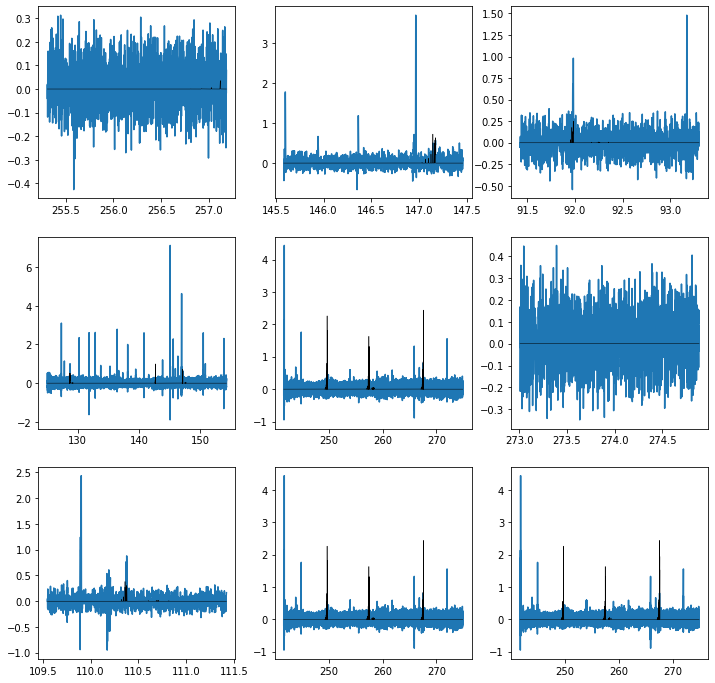

In [16]:
pl.figure(figsize=(12,12))
for ind, ch3cncube in enumerate(cubes):
    ax = pl.subplot(3,3,ind+1)
    
    x,y = map(int, ww.celestial.world_to_pixel(crd))
    T = temp = tempmap[0].data[y,x]
    N = N_tot = colmap[0].data[y,x]
        
    x,y = map(int, ch3cncube.wcs.celestial.world_to_pixel(crd))

    freqs, aij, deg, EU, partfunc = get_molecular_parameters('CH3CN',
                                                             fmin=ch3cncube.spectral_axis.min(),
                                                             fmax=ch3cncube.spectral_axis.max())
    
    
    # TODO: determine this from data
    v_cen = 10*u.km/u.s
    v_disp = 1.5*u.km/u.s

    mod = lte_molecule.generate_model(ch3cncube.spectral_axis, v_cen, v_disp, temp, N_tot,
                              freqs, aij, deg, EU, partfunc)

    data_sp = ch3cncube[:, y, x]
    data_sp_K = data_sp.value * ch3cncube.jtok_factors()
    ax.plot(ch3cncube.spectral_axis.to(u.GHz), data_sp_K)
    ax.plot(ch3cncube.spectral_axis.to(u.GHz),
            mod, linestyle='-', color='k', linewidth=0.5)


In [ ]:
N,T

In [ ]:
ch3cncube.jtok_factors()

In [ ]:
cubefns